In [ ]:
!pip install xgboost
!pip install imblearn

In [14]:
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import concurrent.futures
import itertools

# from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score,train_test_split, StratifiedKFold, GroupKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_roc_curve
from sklearn.metrics.pairwise import _euclidean_distances

from xgboost import XGBClassifier

from sklearn.neighbors import KNeighborsClassifier

from imblearn.combine import SMOTEENN 
from imblearn.under_sampling import EditedNearestNeighbours 
from imblearn.over_sampling import SMOTE 

from collections import Counter

# Base de Dados

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#path = "/content/drive/MyDrive/Dissertação/dados/procucao_gado_MS.csv"
path = '../../dados/df_train_class.csv'
df = pd.read_csv(path, sep=';')

In [3]:
df.sample(10)

,tipificacao_1,tipificacao_2,tipificacao_3,classificacao_estabelecimento,outros_incentivos,pratica_recuperacao_pastagem,fertiirrigacao,ilp,ilpf,ifp,...,med12m_prer_milho,med12m_prer_boi,cnt1m_cl_ituinst,cnt3m_cl_ituinst,cnt6m_cl_ituinst,cnt12m_cl_ituinst,longitude,latitude,mes,categoria
488927,1,0,0,21.0,0,0,0,0,0,0,...,36.69,143.05,0.7419,0.7527,0.6885,0.5601,-54.754906,-17.581355,9,6
633485,0,0,1,21.0,0,0,0,0,0,0,...,36.64,143.03,0.8387,0.8495,0.7978,0.6885,-54.865560,-20.442310,9,1
561583,0,0,1,30.0,0,0,0,0,0,0,...,31.56,139.96,0.7931,0.7011,0.5389,0.5389,-53.761680,-20.443680,6,2
967,0,1,0,21.0,0,0,0,0,0,0,...,30.30,138.70,0.3000,0.4737,0.5465,0.6434,-53.761680,-20.443680,3,3
308696,0,1,0,21.0,0,0,0,0,0,0,...,30.47,138.81,0.1379,0.2530,0.2845,0.3759,-51.710001,-20.788679,12,2
357850,0,0,1,30.0,0,0,0,0,0,0,...,34.25,144.18,0.2333,0.2111,0.2233,0.2233,-56.390198,-20.239333,4,2
74436,1,0,0,21.0,0,0,0,0,0,0,...,31.73,139.28,0.8387,0.6559,0.5304,0.4986,-54.966030,-20.931054,5,4
43564,0,0,1,21.0,0,1,1,0,0,0,...,30.16,138.66,0.1290,0.1828,0.3060,0.3634,-54.758056,-18.508411,2,1
653363,0,0,1,21.0,0,1,0,1,0,0,...,33.03,139.71,0.9032,0.7419,0.6175,0.6721,-54.601323,-22.862472,6,2
582102,1,0,0,26.0,0,0,0,0,0,0,...,36.12,142.89,0.9655,0.9885,0.9728,0.8176,-54.558600,-23.661900,8,4


In [4]:
print('A base de dados apresenta {} registros e {} características.'.format(df.shape[0], df.shape[1]))

A base de dados apresenta 672657 registros e 48 características.


## Desbalanceamento da Classe alvo

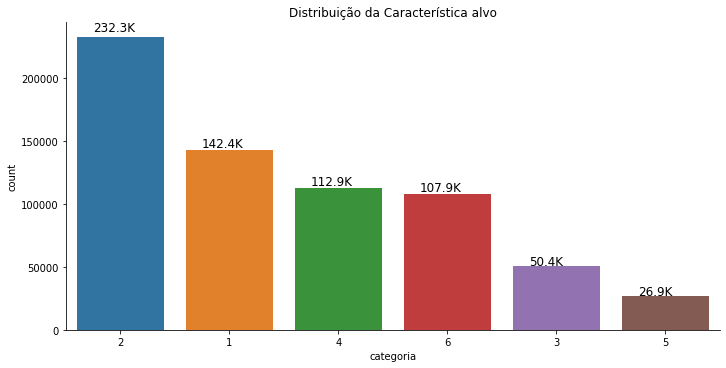

In [7]:
categorias = df.categoria.value_counts()
plot_categoria = sns.catplot(x = "categoria", data = df, 
                             kind="count",
                             aspect=2,
                             order = categorias.index).set(title='Distribuição da Característica alvo')
ax = plot_categoria.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0.15,
            p.get_height() * 1.02,
            '{0:.1f}K'.format(p.get_height()/1000),
            color='black',
            rotation='horizontal',
            size='large')

In [2]:
path = '../../dados/df_train_class.csv'
df = pd.read_csv(path, sep=';')

In [3]:
print('A base de dados apresenta {} registros e {} características.'.format(df.shape[0], df.shape[1]))

A base de dados apresenta 672657 registros e 48 características.


## Características preditoras do atributo alvo

In [9]:
# Valor para garantir que o método tenha comportamento aleatório, porém igual em todas as vezes que executado
SEED = 42

In [10]:
y = df['categoria']
# Retirar a variável alvo e as variáveis obtidas após o abate 
X = df.drop(['categoria'],axis=1)

## StandardScaler

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## PCA

In [15]:
pca = PCA(n_components=30)
pca.fit(X_scaled)
X_scaled_pca = pca.transform(X_scaled)

## ENN - Edited Nearest Neighbour
Subamostragem com base no método do vizinho mais próximo. 

In [10]:
enn = EditedNearestNeighbours(n_jobs=-1)
X_enn, y_enn = enn.fit_resample(X_scaled, y)

In [ ]:
print('Dados originais: {}'.format(Counter(y)))
print('Dados reamostrados: {}'.format(Counter(y_enn)))

In [ ]:
# Conjunto de dados reamostrados para arquivo csv
df_X_enn = pd.DataFrame(X_enn)
df_train_enn = df_X_enn.join(y_enn)
df_train_enn.to_csv("dados_train_enn.csv", sep=';', index=False)

## SMOTE - Synthetic Minority Over-sampling Technique
Sobreamostragem 

In [ ]:
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X_scaled, y)

In [ ]:
print('Dados originais: {}'.format(Counter(y)))
print('Dados reamostrados: {}'.format(Counter(y_sm)))

In [ ]:
# Conjunto de dados reamostrados para arquivo csv
df_X_sm = pd.DataFrame(X_sm)
df_train_sm = df_X_sm.join(y_sm)
df_train_sm.to_csv("dados_train_sm.csv", sep=';', index=False)

## SMOTEENN - SMOTE e Edited Nearest Neighbours 

Sobreamostragem combinando SMOTE e limpeza com ENN.

In [ ]:
smote_enn = SMOTEENN(random_state=SEED, n_jobs=-1)
X_smoteenn, y_smoteenn = smote_enn.fit_resample(X_scaled, y)

In [ ]:
print('Dados originais: {}'.format(Counter(y)))
print('Dados reamostrados: {}'.format(Counter(y_smoteenn)))

In [ ]:
# Conjunto de dados reamostrados para arquivo csv
df_X_smoteenn = pd.DataFrame(X_smoteenn)
df_train_smoteenn = df_X_smoteenn.join(y_smoteenn)
df_train_smoteenn.to_csv("dados_train_smoteenn.csv", sep=';', index=False)

# Gráficos

In [31]:
def categoria_catplot(y, metodo):
    df_y = pd.DataFrame(y)
    plot = sns.catplot(x = "categoria", data = df_y, 
            kind="count", 
            aspect=2).set(title='Distribuição da Característica alvo após ' + metodo)

    ax = plot.facet_axis(0,0)
    for p in ax.patches:
        ax.text(p.get_x() + 0.15, 
                p.get_height() * 1.02, 
               '{0:.1f}K'.format(p.get_height()/1000),   #Used to format it K representation
                color='black', 
                rotation='horizontal', 
                size='large')

In [4]:
nomes_colunas = ['tipificacao_1', 'tipificacao_2', 'tipificacao_3',
       'classificacao_estabelecimento', 'outros_incentivos',
       'pratica_recuperacao_pastagem', 'fertiirrigacao', 'ilp', 'ilpf', 'ifp',
       'fabrica_racao', 'identificacao_individual', 'regua_de_manejo', 'bpa',
       'participa_aliancas_mercadologicas', 'rastreamento_sisbov',
       'tot1m_chuva', 'med1m_formituinst', 'med1m_ndvi', 'med1m_prer_soja',
       'med1m_prer_milho', 'med1m_prer_boi', 'tot3m_chuva',
       'med3m_formituinst', 'med3m_ndvi', 'med3m_prer_soja',
       'med3m_prer_milho', 'med3m_prer_boi', 'tot6m_chuva',
       'med6m_formituinst', 'med6m_ndvi', 'med6m_prer_soja',
       'med6m_prer_milho', 'med6m_prer_boi', 'tot12m_chuva',
       'med12m_formituinst', 'med12m_ndvi', 'med12m_prer_soja',
       'med12m_prer_milho', 'med12m_prer_boi', 'cnt1m_cl_ituinst',
       'cnt3m_cl_ituinst', 'cnt6m_cl_ituinst', 'cnt12m_cl_ituinst',
       'longitude', 'latitude', 'mes', 'categoria']

In [3]:
df_enn = pd.read_csv('../../dados/dados_train_enn.csv', sep=';')

In [5]:
df_enn.columns = nomes_colunas

In [33]:
df_sm = pd.read_csv('dados/dados_train_sm.csv', sep=';')

In [34]:
df_smoteenn = pd.read_csv('dados/dados_train_smoteenn.csv', sep=';')

In [ ]:
def plot_categoria(df,metodo):
    categorias = df.categoria.value_counts()
    plot_categoria = sns.catplot(x = "categoria", data = df,
                                 kind="count",
                                 aspect=2).set(title='Distribuição da Característica alvo ' + metodo)    
    ax = plot_categoria.facet_axis(0,0)
    for p in ax.patches:
        ax.text(p.get_x() + 0.15,
                p.get_height() * 1.02,
                '{0:.1f}K'.format(p.get_height()/1000),
                color='black',
                rotation='horizontal',
                size='large')

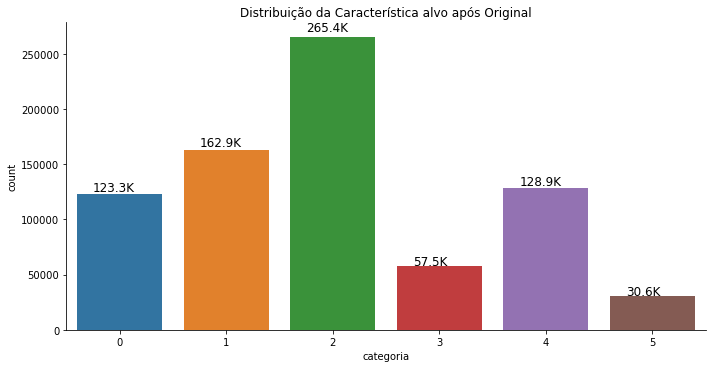

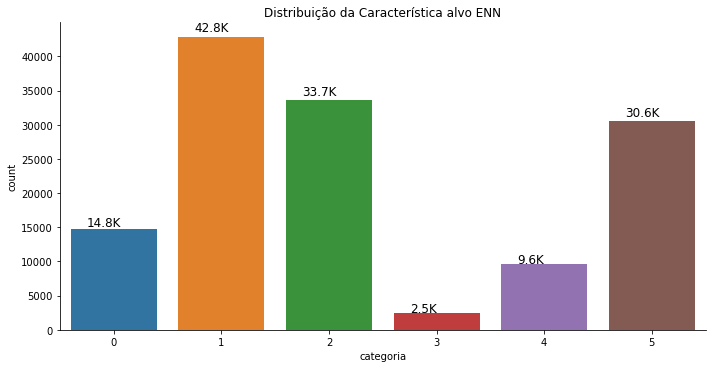

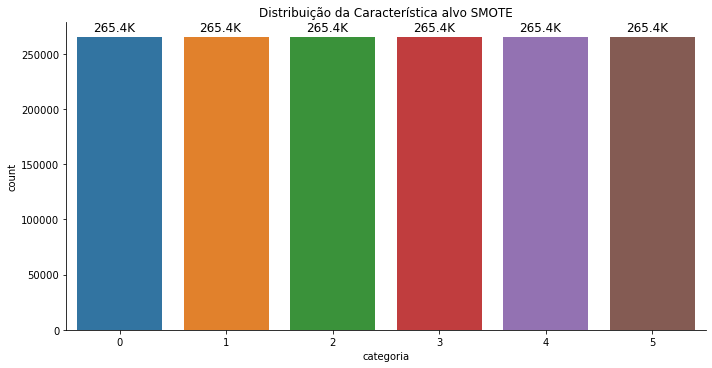

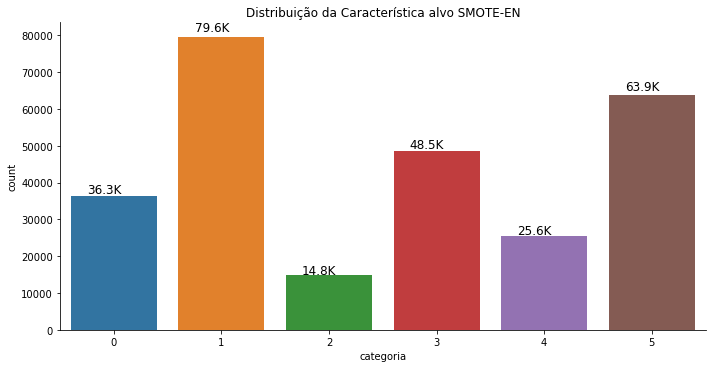

In [35]:
categoria_catplot(y, 'Original')
plot_categoria(df_enn, 'ENN')
plot_categoria(df_sm, 'SMOTE')
plot_categoria(df_smoteenn, 'SMOTE-EN')

# Treinamento com dados balanceados

### XGBClassifier + ENN

In [31]:
y_enn = df_enn['categoria']
# Retirar a variável alvo e as variáveis obtidas após o abate 
X_enn = df_enn.drop(['categoria'],axis=1)

In [ ]:
xgb_enn = XGBClassifier(objective="multi:softmax", num_class= 6, eval_metric='mlogloss', 
                        random_state=SEED, nthread=-1, use_label_encoder=False, **xgb_params)

plot_learning_curve(xgb_enn, X_enn, y_enn, cv=kfolds)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_enn, y_enn, test_size=.2)

In [ ]:
# Matriz de confusão
xgb_enn.fit(X_train, y_train)
pred = xgb_enn.predict(X_test)
matrix = confusion_matrix(y_pred=pred, y_true=y_test)
plot_confusion_matrix(matrix, ['0','1', '2', '3', '4', '5'])

In [ ]:
print(classification_report(y_pred=pred, y_true=y_test))

### XGBClassifier + SMOTE

In [ ]:
xgb_sm = XGBClassifier(objective="multi:softmax", num_class= 6, eval_metric='mlogloss', 
                        random_state=SEED, nthread=-1, use_label_encoder=False, **xgb_params)

plot_learning_curve(xgb_enn, X_enn, y_enn, cv=kfolds)

### XGBClassifier + SMOTEENN

In [ ]:
xgb = XGBClassifier(objective="multi:softmax", num_class= 6, eval_metric='mlogloss', 
                    random_state=SEED, nthread=-1, use_label_encoder=False, **xgb_params)
t0 = time.time()
score = cross_val_score(xgb, X_resampled, y_resampled_xgb, cv = kfolds,  n_jobs=-1, pre_dispatch=2, error_score='raise')
print('A pontuação média da validação cruzada : %0.3f"' % score.mean())
print("Pronto em:  %0.3f" %(time.time()-t0))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled_xgb, test_size=.2, random_state=SEED)

xgb = XGBClassifier(objective="multi:softmax", num_class= 6, eval_metric='mlogloss', random_state=SEED, nthread=-1, use_label_encoder=False)
plot_learning_curve(xgb, X_train, y_train, cv=10)

In [ ]:
# Matriz de confusão
xgb = XGBClassifier(objective="multi:softmax", num_class= 6, eval_metric='mlogloss', random_state=SEED, nthread=-1, use_label_encoder=False)
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)
matrix = confusion_matrix(y_pred=pred, y_true=y_test)
plot_confusion_matrix(matrix, ['1', '2', '3', '4', '5', '0'])

In [ ]:
print(classification_report(y_pred=pred, y_true=y_test))

## RFC + ENN

In [6]:
y_enn = df_enn['categoria']
# Retirar a variável alvo e as variáveis obtidas após o abate 
X_enn = df_enn.drop(['categoria'],axis=1)

In [10]:
rfr_enn = RandomForestClassifier(n_jobs=-1, random_state=SEED, **rfc_params)

Score_in:  0.9931895568120251
Score_out:  0.6305797381509763


<module 'matplotlib.pyplot' from '/home/ygobrito/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

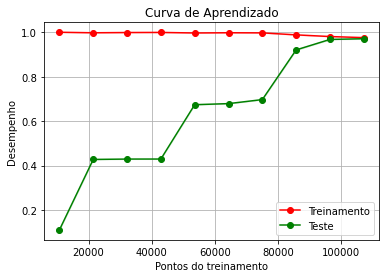

In [16]:
plot_learning_curve(rfr_enn, X_enn, y_enn, cv=skfolds)

Confusion matrix, without normalization
[[2813    6   14    0    6  136]
 [   0 8454    0    0    0   16]
 [   0    7 6741    0    5   52]
 [   0    1    0  430    0   47]
 [   4    1    3    0 1911   80]
 [ 126   41  138   52   76 5649]]


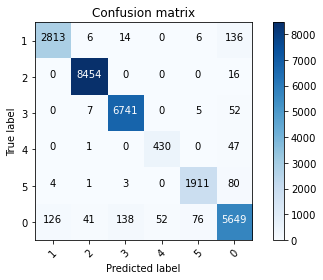

In [14]:
# Matriz de confusão
X_train, X_test, y_train, y_test = train_test_split(X_enn, y_enn, test_size=.2)

rfr_enn.fit(X_train, y_train)
pred = rfr_enn.predict(X_test)
matrix = confusion_matrix(y_pred=pred, y_true=y_test)
plot_confusion_matrix(matrix, ['1', '2', '3', '4', '5', '0'])

In [17]:
print(classification_report(y_pred=pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      2975
           1       0.99      1.00      1.00      8470
           2       0.98      0.99      0.98      6805
           3       0.89      0.90      0.90       478
           4       0.96      0.96      0.96      1999
           5       0.94      0.93      0.94      6082

    accuracy                           0.97     26809
   macro avg       0.95      0.95      0.95     26809
weighted avg       0.97      0.97      0.97     26809



In [34]:
path = 'dados/procucao_gado_MS_test.csv'
df_teste = pd.read_csv(path, sep=';')

In [35]:
y = df_teste['categoria']
# Retirar a variável alvo e as variáveis obtidas após o abate 
X = df_teste.drop(['categoria'],axis=1)

In [36]:
y=y.replace(6, 0)

In [37]:
pred = rfr_enn.predict(X)

Confusion matrix, without normalization
[[    0  6762 15876     0   165  7858]
 [    0 21212 14320     0   210  4723]
 [    2 21727 30841     0   365 13916]
 [    1  2969  2817     0     0  8373]
 [    0  6919 17301     0   202  8061]
 [    3   474   689     0     0  6402]]


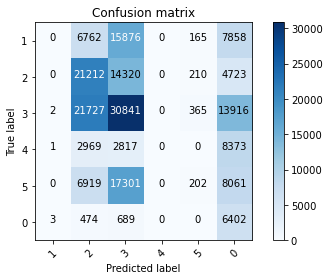

In [39]:
matrix = confusion_matrix(y_pred=pred, y_true=y)
plot_confusion_matrix(matrix, ['0','1', '2', '3', '4', '5'])

Confusion matrix, without normalization
[[    0  6762 15876     0   165  7858]
 [    0 21212 14320     0   210  4723]
 [    2 21727 30841     0   365 13916]
 [    1  2969  2817     0     0  8373]
 [    0  6919 17301     0   202  8061]
 [    3   474   689     0     0  6402]]


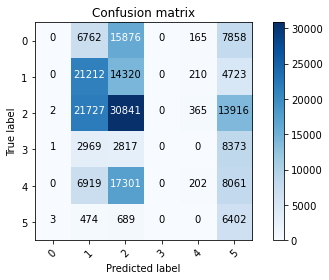

In [40]:
matrix = confusion_matrix(y_pred=pred, y_true=y)
plot_confusion_matrix(matrix, ['0','1', '2', '3', '4', '5'])

print(classification_report(y_pred=pred, y_true=y))

### RFC + SMOTE

In [16]:
y_sm = df_sm['categoria']
# Retirar a variável alvo e as variáveis obtidas após o abate 
X_sm = df_sm.drop(['categoria'],axis=1)

In [17]:
rfr_sm = RandomForestClassifier(n_jobs=-1, random_state=SEED, **rfc_params)

KeyboardInterrupt: 

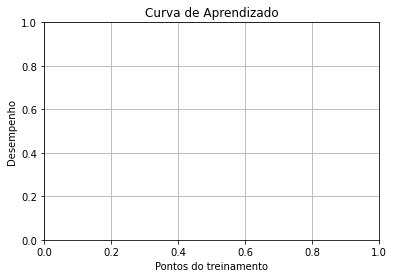

In [19]:
plot_learning_curve(rfr_sm, X_sm, y_sm, cv=skfolds)

In [ ]:
# Matriz de confusão
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=.2)

rfr_sm.fit(X_train, y_train)
pred = rfc.predict(X_test)
matrix = confusion_matrix(y_pred=pred, y_true=y_test)
plot_confusion_matrix(matrix, ['1', '2', '3', '4', '5', '0'])